In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
BN_MOMENTUM=0.1
class Simple1DCNN(nn.Module):
    def __init__(self,n,p):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(5, 32*n, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(32*n, 32*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(32*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32*n, 64*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(64*n, 64*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(64*n, 128*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.conv6 = nn.Sequential(
            nn.Conv1d(128*n, 128*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(128*n*6,128*n*6),
            nn.ReLU(),
            nn.Linear(6*128*n,3),
        )
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def forward(self, x):
        x=x.to(self.device)
        x= torch.transpose(x,1,2)
        x= self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x=x.view(x.size(0),-1)
        x= self.linear1(x)
        return x

In [ ]:
import math
import copy
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, ninp=70, nhead=7, nhid=70, nlayers=4, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        #self.pos_encoder = PositionalEncoding(ninp)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.embedding = nn.Linear(5,70)
        self.classification = nn.Linear(420,3)


    def generate_square_subsequent_mask(self):
        mask = (torch.triu(torch.ones(6, 6)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, src_mask):
        a,b=src.size(0),src.size(1)
        src = src.view(a*b,-1)
        src = self.embedding(src)
        src = src.view(a,b,-1)
        src = src.transpose(0,1)
        #src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output.transpose(0,1)
        output = output.reshape(output.size(0),-1)
        output = self.classification(output)
        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=6):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / 12))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        #self.data = np.concatenate((data[:,:,:5],data[:,:,6:]),axis=2)
        self.data = data[:,:,:5]
        self.labels = labels
        self.labels[self.labels==3]=0
        for i in range(len(self.data)):
          self.data[i, :,:4] = (self.data[i, :,:4]-1)*100
          self.data[i, :,4] = self.data[i, :,4]*0.1
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
train_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_data_09011000_3000_05_1107.npy')
val_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_data_09011000_3000_05_1107.npy')
test_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_data_09011000_3000_05_1107.npy')

train_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_labels_09011000_3000_05_1107.npy')
val_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_labels_09011000_3000_05_1107.npy')
test_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_labels_09011000_3000_05_1107.npy')

In [ ]:
train_dataset = SimpleDataset(train_data,train_labels)
val_dataset = SimpleDataset(val_data,val_labels)
test_dataset = SimpleDataset(test_data,test_labels)

In [ ]:
train_dataset[150]

(array([[-1.48849797, -1.35317997, -1.62381597, -1.35317997,  0.21751009],
        [-1.35317997, -1.08254398, -1.35317997, -1.08254398,  0.01648174],
        [-1.35317997, -1.08254398, -1.48849797, -1.35317997,  0.10556324],
        [-1.21786198, -1.21786198, -1.48849797, -1.35317997,  0.18841681],
        [-1.35317997, -1.21786198, -1.48849797, -1.35317997,  0.07017531],
        [-1.35317997, -1.21786198, -1.48849797, -1.48849797,  0.11688471]]),
 1.0)

In [ ]:
len(train_data)

228279

In [ ]:
len(val_data)

28183

In [ ]:
len(test_data)

25365

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=False)
train_dataloader2 = DataLoader(train_dataset, batch_size=1024, shuffle=False, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, drop_last=False)

In [ ]:
from tqdm.auto import tqdm

model = Simple1DCNN(1,0.0).to('cuda')
#loss_fn = nn.CrossEntropyLoss(reduction='none')
loss_fn = FocalLoss(alpha=torch.tensor([.4, .4, .2]).to('cuda'), gamma=2)
lr = 0.001 # 학습률
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3],gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

train_accs = []
val_accs = []

train_losses = []
val_losses = []
tf=0
for epoch in range(3):
    #epoch_loss = []
    model.train()
    train_loss_sum = 0
    sum_acc=0
    total_cnt=0
    step=0
    for data,gt in tqdm(train_dataloader):
        optimizer.zero_grad()
        data = data.float()
        out=model(data)
        gt = gt.long().to('cuda')
        #gt = torch.tensor(gt, dtype=torch.long).to('cuda')
        loss = loss_fn(out,gt)
        c=torch.argmax(out,dim=1)
        #loss=loss.mean()
        loss.backward()
        train_loss_sum += loss.item()
        optimizer.step()
        #scheduler.step()
        sum_acc+=torch.sum(c==gt)
        total_cnt+=len(gt)
        if step%450==0 or tf==0:
          train_accs.append(sum_acc/total_cnt)
          train_losses.append(train_loss_sum/(step+1))
          print("training : acc - {}, loss - {}".format(sum_acc/total_cnt,train_loss_sum/(step+1)))
          total_cnt=0
          sum_acc=0
          train_loss_sum=0
          step=0
          tf=1
          with torch.no_grad():
            outs2 = []
            val_loss_sum = 0
            sum_acc2=0
            total_cnt2=0
            for data, gt in val_dataloader:
              data = data.float().cuda()
              out=model(data)
              gt = gt.long().to('cuda')
              loss_v = loss_fn(out,gt)
              #loss_v = loss_v.mean()
              c=torch.argmax(out,dim=1)
              sum_acc2+=torch.sum(c==gt)
              total_cnt2+=len(gt)
              outs2 += c.cpu().detach().numpy().tolist()
              val_loss_sum += loss_v.item()
          val_accs.append(sum_acc2/total_cnt2)
          val_losses.append(val_loss_sum/len(val_dataloader))
          print("validation : acc - {}, loss - {}".format(sum_acc2/total_cnt2,val_loss_sum/len(val_dataloader)))
        step+=1
        
    #train_accs.append(sum_acc/total_cnt)
    #train_losses.append(train_loss_sum/len(train_dataloader))
    
    model.eval()
    outs = []
    outs2 = []
    val_loss_sum = 0
    with torch.no_grad():
        sum_acc=0
        total_cnt=0
        sum_acc2=0
        total_cnt2=0
        total_loss_t=0
        total_loss_v=0
        for data, gt in train_dataloader2:
            data = data.float().cuda()
            out=model(data)
            gt = gt.long().to('cuda')
            #gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            loss_t = loss_fn(out,gt)
            #loss_t = loss_t.mean()
            total_loss_t+=loss_t.item()
            c=torch.argmax(out,dim=1)
            sum_acc+=torch.sum(c==gt)
            total_cnt+=len(gt)
            outs += c.cpu().detach().numpy().tolist()
        
        for data, gt in val_dataloader:
            data = data.float().cuda()
            out=model(data)
            gt = gt.long().to('cuda')
            #gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            loss_v = loss_fn(out,gt)
            #loss_v = loss_v.mean()
            total_loss_v+=loss_v.item()
            c=torch.argmax(out,dim=1)
            sum_acc2+=torch.sum(c==gt)
            total_cnt2+=len(gt)
            outs2 += c.cpu().detach().numpy().tolist()
            #val_loss_sum += loss_v.item()
        #val_accs.append(sum_acc2/total_cnt2)
        #val_losses.append(val_loss_sum/len(val_dataloader))
        
    _00 = np.logical_and((train_labels == 0), (np.array(outs) == 0)).sum()
    _11 = np.logical_and((train_labels == 1), (np.array(outs) == 1)).sum()
    _22 = np.logical_and((train_labels == 2), (np.array(outs) == 2)).sum()
    
    _01 = np.logical_and((train_labels == 0), (np.array(outs) == 1)).sum()
    _02 = np.logical_and((train_labels == 0), (np.array(outs) == 2)).sum()
    _10 = np.logical_and((train_labels == 1), (np.array(outs) == 0)).sum()
    _12 = np.logical_and((train_labels == 1), (np.array(outs) == 2)).sum()
    _20 = np.logical_and((train_labels == 2), (np.array(outs) == 0)).sum()
    _21 = np.logical_and((train_labels == 2), (np.array(outs) == 1)).sum()

    twinrate= _22/(_02+_12+_22)
    tloserate= _02/(_02+_12+_22)

    val_00 = np.logical_and((val_labels == 0), (np.array(outs2) == 0)).sum()
    val_11 = np.logical_and((val_labels == 1), (np.array(outs2) == 1)).sum()
    val_22 = np.logical_and((val_labels == 2), (np.array(outs2) == 2)).sum()
    
    val_01 = np.logical_and((val_labels == 0), (np.array(outs2) == 1)).sum()
    val_02 = np.logical_and((val_labels == 0), (np.array(outs2) == 2)).sum()
    val_10 = np.logical_and((val_labels == 1), (np.array(outs2) == 0)).sum()
    val_12 = np.logical_and((val_labels == 1), (np.array(outs2) == 2)).sum()
    val_20 = np.logical_and((val_labels == 2), (np.array(outs2) == 0)).sum()
    val_21 = np.logical_and((val_labels == 2), (np.array(outs2) == 1)).sum()

    winrate= val_22/(val_02+val_12+val_22)
    loserate= val_02/(val_02+val_12+val_22)

    print("current epoch{} - train accuracy : {}, train loss : {}, win rate: {}, lose rate: {}, buy #: {}".format(epoch,sum_acc/total_cnt, total_loss_t/len(train_dataloader),twinrate,tloserate, (_02+_12+_22)/len(train_dataset))) 
    print("current epoch{} - valid accuracy : {}, valid loss : {}, win rate: {}, lose rate: {}, buy #: {}\n".format(epoch,sum_acc2/total_cnt2, total_loss_v/len(val_dataloader), winrate,loserate, (val_02+val_12+val_22)/len(val_dataset)))
    '''
    if (sum_acc/total_cnt>0.53) and (winrate > 0.57) and (twinrate> 0.57) and (TP2+FP2)/1330>0.25:
      torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/cnn_1028.pt')
      break
    '''

  0%|          | 0/4501 [00:00<?, ?it/s]

training : acc - 0.310546875, loss - 0.16436037421226501
validation : acc - 0.3498394191265106, loss - 0.26380884178895936
training : acc - 0.4871028661727905, loss - 0.1306442541881834
validation : acc - 0.5125657916069031, loss - 0.12702110081540544
training : acc - 0.5117795467376709, loss - 0.12576566740639195
validation : acc - 0.5145049691200256, loss - 0.12520270323509858
training : acc - 0.5185568928718567, loss - 0.12469329390914372
validation : acc - 0.5157427787780762, loss - 0.12465354806841161
training : acc - 0.5184960961341858, loss - 0.12440439198009191
validation : acc - 0.5225204229354858, loss - 0.12475316757154295
training : acc - 0.5206987857818604, loss - 0.1238492794021006
validation : acc - 0.5208121538162231, loss - 0.12412279832373715
training : acc - 0.5213845372200012, loss - 0.12369100957646338
validation : acc - 0.5270360112190247, loss - 0.12444195685971059
training : acc - 0.5219205617904663, loss - 0.1235678578064077
validation : acc - 0.518048286437988

  0%|          | 0/4501 [00:00<?, ?it/s]

training : acc - 0.525390625, loss - 0.12513136863708496
validation : acc - 0.5256332159042358, loss - 0.12366783393953876
training : acc - 0.5245247483253479, loss - 0.12307976182971456
validation : acc - 0.52116459608078, loss - 0.12372272977767575
training : acc - 0.5238910913467407, loss - 0.12299632388445861
validation : acc - 0.5249961018562317, loss - 0.12405799980379549
training : acc - 0.525583803653717, loss - 0.12294909670255137
validation : acc - 0.5155692100524902, loss - 0.12350949200389652
training : acc - 0.5261675715446472, loss - 0.12257853964810361
validation : acc - 0.5239405632019043, loss - 0.12339386682739055
training : acc - 0.5264257788658142, loss - 0.12281164279137377
validation : acc - 0.5276713967323303, loss - 0.1230800984490193
training : acc - 0.5254318714141846, loss - 0.12278985666594326
validation : acc - 0.5195344090461731, loss - 0.12343190634229467
training : acc - 0.5270030498504639, loss - 0.12282143328380161
validation : acc - 0.5278155207633972

  0%|          | 0/4501 [00:00<?, ?it/s]

training : acc - 0.513671875, loss - 0.1195974349975586
validation : acc - 0.5167757868766785, loss - 0.12338668756438402
training : acc - 0.5282986164093018, loss - 0.12209338448660866
validation : acc - 0.5258224606513977, loss - 0.12270629059252053
training : acc - 0.5276497602462769, loss - 0.12218380778895778
validation : acc - 0.5292981266975403, loss - 0.1228533914812293
training : acc - 0.5284613966941833, loss - 0.12225724411446874
validation : acc - 0.5263172388076782, loss - 0.12272071356671742
training : acc - 0.527050793170929, loss - 0.12230806506988479
validation : acc - 0.526115894317627, loss - 0.12265526274381268
training : acc - 0.528062105178833, loss - 0.12229422483171962
validation : acc - 0.5256332159042358, loss - 0.12276618438069817
training : acc - 0.5274305939674377, loss - 0.12225451383186285
validation : acc - 0.5270498991012573, loss - 0.12260668415106422
training : acc - 0.5292274355888367, loss - 0.12185659586656385
validation : acc - 0.5315619707107544,

In [ ]:
val_accs2 = val_accs[0:11]+val_accs[12:23]+val_accs[24:35]
val_accs2

<function matplotlib.pyplot.show>

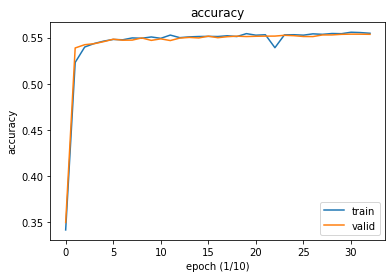

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs)
plt.plot(val_accs2)
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch (1/10)')
plt.legend(['train','valid'],loc='lower right')
plt.show

In [ ]:
val_losses2 = val_losses[0:11]+val_losses[12:23]+val_losses[24:35]

<function matplotlib.pyplot.show>

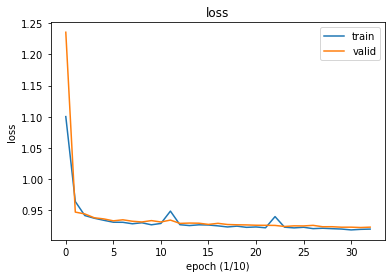

In [ ]:
train_losses = (np.array(train_losses)).tolist()
val_losses = (np.array(val_losses)).tolist()
plt.plot(train_losses)
plt.plot(val_losses2)
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch (1/10)')
plt.legend(['train','valid'],loc='upper right')
plt.show

In [ ]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.
    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.
    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [ ]:
from tqdm.auto import tqdm
model = TransformerModel(ninp=70,nhid=70,nlayers=6,nhead=7,dropout=0.0).to('cuda')
#model = TransformerModel(ninp=5,nhid=5,nlayers=6,nhead=5,dropout=0.0).to('cuda')
#loss_fn = nn.CrossEntropyLoss(reduction='none')
loss_fn = FocalLoss(alpha=torch.tensor([.375, .375, .25]).to('cuda'), gamma=2)
lr = 0.001 # 학습률
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_accs = []
val_accs = []

train_losses = []
val_losses = []
tf=0
for epoch in range(5):
    #epoch_loss = []
    model.train()
    train_loss_sum = 0
    sum_acc=0
    total_cnt=0
    step=0
    for data,gt in tqdm(train_dataloader):
        optimizer.zero_grad()
        data = data.float().to('cuda')
        src_mask=model.generate_square_subsequent_mask().to('cuda')
        out=model(data,src_mask)
        gt = torch.tensor(gt, dtype=torch.long).to('cuda')
        loss = loss_fn(out,gt)
        c=torch.argmax(out,dim=1)
        #loss=loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        train_loss_sum += loss.item()
        optimizer.step()
        #scheduler.step()
        sum_acc+=torch.sum(c==gt)
        total_cnt+=len(gt)
        if step%450==0 or tf==0:
          train_accs.append(sum_acc/total_cnt)
          train_losses.append(train_loss_sum/(step+1))
          print("training : acc - {}, loss - {}".format(sum_acc/total_cnt,train_loss_sum/(step+1)))
          total_cnt=0
          sum_acc=0
          train_loss_sum=0
          step=0
          tf=1
          with torch.no_grad():
            val_loss_sum = 0
            sum_acc2=0
            total_cnt2=0
            for data, gt in val_dataloader:
              data = data.float().cuda()
              src_mask=model.generate_square_subsequent_mask().to('cuda')
              out=model(data,src_mask)
              gt = torch.tensor(gt, dtype=torch.long).to('cuda')
              loss_v = loss_fn(out,gt)
              #loss_v = loss_v.mean()
              c=torch.argmax(out,dim=1)
              sum_acc2+=torch.sum(c==gt)
              total_cnt2+=len(gt)
              val_loss_sum += loss_v.item()
          val_accs.append(sum_acc2/total_cnt2)
          val_losses.append(val_loss_sum/len(val_dataloader))
          print("validation : acc - {}, loss - {}".format(sum_acc2/total_cnt2,val_loss_sum/len(val_dataloader)))
        step+=1
        
    #train_accs.append(sum_acc/total_cnt)
    #train_losses.append(train_loss_sum/len(train_dataloader))
    
    model.eval()
    outs = []
    outs2 = []
    val_loss_sum = 0
    with torch.no_grad():
        sum_acc=0
        total_cnt=0
        sum_acc2=0
        total_cnt2=0
        total_loss_t=0
        total_loss_v=0
        for data, gt in train_dataloader2:
            data = data.float().cuda()
            src_mask=model.generate_square_subsequent_mask().to('cuda')
            out=model(data,src_mask)
            gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            loss_t = loss_fn(out,gt)
            #loss_t = loss_t.mean()
            total_loss_t+=loss_t.item()
            c=torch.argmax(out,dim=1)
            sum_acc+=torch.sum(c==gt)
            total_cnt+=len(gt)
            outs += c.cpu().detach().numpy().tolist()
        
        for data, gt in val_dataloader:
            data = data.float().cuda()
            src_mask=model.generate_square_subsequent_mask().to('cuda')
            out=model(data,src_mask)
            gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            loss_v = loss_fn(out,gt)
            #loss_v = loss_v.mean()
            total_loss_v+=loss_v.item()
            c=torch.argmax(out,dim=1)
            sum_acc2+=torch.sum(c==gt)
            total_cnt2+=len(gt)
            outs2 += c.cpu().detach().numpy().tolist()
            #val_loss_sum += loss_v.item()
        #val_accs.append(sum_acc2/total_cnt2)
        #val_losses.append(val_loss_sum/len(val_dataloader))
        
    _00 = np.logical_and((train_labels == 0), (np.array(outs) == 0)).sum()
    _11 = np.logical_and((train_labels == 1), (np.array(outs) == 1)).sum()
    _22 = np.logical_and((train_labels == 2), (np.array(outs) == 2)).sum()
    
    _01 = np.logical_and((train_labels == 0), (np.array(outs) == 1)).sum()
    _02 = np.logical_and((train_labels == 0), (np.array(outs) == 2)).sum()
    _10 = np.logical_and((train_labels == 1), (np.array(outs) == 0)).sum()
    _12 = np.logical_and((train_labels == 1), (np.array(outs) == 2)).sum()
    _20 = np.logical_and((train_labels == 2), (np.array(outs) == 0)).sum()
    _21 = np.logical_and((train_labels == 2), (np.array(outs) == 1)).sum()

    twinrate= _22/(_02+_12+_22)
    tloserate= _02/(_02+_12+_22)

    val_00 = np.logical_and((val_labels == 0), (np.array(outs2) == 0)).sum()
    val_11 = np.logical_and((val_labels == 1), (np.array(outs2) == 1)).sum()
    val_22 = np.logical_and((val_labels == 2), (np.array(outs2) == 2)).sum()
    
    val_01 = np.logical_and((val_labels == 0), (np.array(outs2) == 1)).sum()
    val_02 = np.logical_and((val_labels == 0), (np.array(outs2) == 2)).sum()
    val_10 = np.logical_and((val_labels == 1), (np.array(outs2) == 0)).sum()
    val_12 = np.logical_and((val_labels == 1), (np.array(outs2) == 2)).sum()
    val_20 = np.logical_and((val_labels == 2), (np.array(outs2) == 0)).sum()
    val_21 = np.logical_and((val_labels == 2), (np.array(outs2) == 1)).sum()

    winrate= val_22/(val_02+val_12+val_22)
    loserate= val_02/(val_02+val_12+val_22)
    
    print("current epoch{} - train accuracy : {}, train loss : {}, win rate: {}, lose rate: {}, buy #: {}".format(epoch,sum_acc/total_cnt, total_loss_t/len(train_dataloader),twinrate,tloserate, (_02+_12+_22)/len(train_dataset))) 
    print("current epoch{} - valid accuracy : {}, valid loss : {}, win rate: {}, lose rate: {}, buy #: {}\n".format(epoch,sum_acc2/total_cnt2, total_loss_v/len(val_dataloader), winrate,loserate, (val_02+val_12+val_22)/len(val_dataset)))
    #torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/transformer_{}_1107_3000_finetunning_5features.pt'.format(epoch))
    
    

  0%|          | 0/1046 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


training : acc - 0.30859375, loss - 0.29853641986846924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation : acc - 0.4086037874221802, loss - 0.17929989191202017
training : acc - 0.503331184387207, loss - 0.13884511811373768
validation : acc - 0.5037399530410767, loss - 0.14088590477521604
training : acc - 0.5201953053474426, loss - 0.13466257626756598
validation : acc - 0.5267771482467651, loss - 0.13477835127940543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch0 - train accuracy : 0.5187593102455139, train loss : 0.13391196398673505, win rate: 0.6334396936821953, lose rate: 0.24722399489470326, buy #: 0.007315674872174105
current epoch0 - valid accuracy : 0.5193199515342712, valid loss : 0.13368650382527938, win rate: 0.6334405144694534, lose rate: 0.2658092175777063, buy #: 0.007056367747937166



  0%|          | 0/1046 [00:00<?, ?it/s]

training : acc - 0.5400390625, loss - 0.133713036775589
validation : acc - 0.5211501717567444, loss - 0.13358156256950818
training : acc - 0.5244205594062805, loss - 0.1333614315366798
validation : acc - 0.5237972736358643, loss - 0.13321920432723486
training : acc - 0.5273958444595337, loss - 0.13276231183181053
validation : acc - 0.5269813537597656, loss - 0.13297119644971994
current epoch1 - train accuracy : 0.5360769629478455, train loss : 0.1315314751082807, win rate: 0.5632516666942381, lose rate: 0.32958361594071034, buy #: 0.05644227573044703
current epoch1 - valid accuracy : 0.5367453098297119, valid loss : 0.13116419286682054, win rate: 0.5694164989939637, lose rate: 0.3276995305164319, buy #: 0.0563828741274079



  0%|          | 0/1046 [00:00<?, ?it/s]

training : acc - 0.5302734375, loss - 0.13268142938613892
validation : acc - 0.5338335037231445, loss - 0.13210725990625527
training : acc - 0.5295703411102295, loss - 0.1322445202693178
validation : acc - 0.5326234102249146, loss - 0.1313919044457949
training : acc - 0.5301758050918579, loss - 0.131723777946506
validation : acc - 0.5351570248603821, loss - 0.13114998632898697
current epoch2 - train accuracy : 0.5305745601654053, train loss : 0.13110001842503793, win rate: 0.6426353915143153, lose rate: 0.2372082327239278, buy #: 0.016241078331409874
current epoch2 - valid accuracy : 0.5308687686920166, valid loss : 0.13089030442329552, win rate: 0.6450417052826691, lose rate: 0.24837812789620017, buy #: 0.016321159271220156



  0%|          | 0/1046 [00:00<?, ?it/s]

training : acc - 0.529296875, loss - 0.13087928295135498
validation : acc - 0.5304301381111145, loss - 0.1312622563770184


KeyboardInterrupt: ignored

In [ ]:
torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/transformer_1102.pt')

In [ ]:
model = TransformerModel(ninp=70,nhid=70,nlayers=4,nhead=7,dropout=0.5).to('cuda')
loss_fn = nn.CrossEntropyLoss(reduction='none')
lr = 0.001 # 학습률
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(300):
    #epoch_loss = []
    model.train()
    for data,gt in train_dataloader:
        optimizer.zero_grad()
        data = data.float().to('cuda')
        src_mask=model.generate_square_subsequent_mask().to('cuda')
        out=model(data,src_mask)
        gt = torch.tensor(gt, dtype=torch.long).to('cuda')
        loss = loss_fn(out,gt)
        c=torch.argmax(out,dim=1)
        loss=loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()
        #sum_acc+=torch.sum(c==gt)
        #total_cnt+=len(gt)
    #print("current epoch{} - train accuracy : {}".format(epoch,sum_acc/total_cnt))
    
    model.eval()
    outs = []
    outs2 = []
    with torch.no_grad():
        sum_acc=0
        total_cnt=0
        sum_acc2=0
        total_cnt2=0
        for data, gt in train_dataloader2:
            data = data.float().cuda()
            src_mask=model.generate_square_subsequent_mask().to('cuda')
            out=model(data,src_mask)
            gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            c=torch.argmax(out,dim=1)
            sum_acc+=torch.sum(c==gt)
            total_cnt+=len(gt)
            outs += c.cpu().detach().numpy().tolist()
        
        for data, gt in val_dataloader:
            data = data.float().cuda()
            src_mask=model.generate_square_subsequent_mask().to('cuda')
            out=model(data,src_mask)
            gt = torch.tensor(gt, dtype=torch.long).to('cuda')
            c=torch.argmax(out,dim=1)
            sum_acc2+=torch.sum(c==gt)
            total_cnt2+=len(gt)
            outs2 += c.cpu().detach().numpy().tolist()
        
    TP = np.logical_and((train_labels == 1), (np.array(outs) == 1)).sum()
    FP = np.logical_and((train_labels == 0), (np.array(outs) == 1)).sum()
    twinrate= TP/(TP+FP)
    TP2 = np.logical_and((val_labels == 1), (np.array(outs2) == 1)).sum()
    FP2 = np.logical_and((val_labels == 0), (np.array(outs2) == 1)).sum()
    winrate= TP2/(TP2+FP2)
                # outs = np.concatenate((outs, out.cpu().detach().numpy()), axis=0)
    print("current epoch{} - train accuracy : {}, win rate: {}, buy #: {}".format(epoch,sum_acc/total_cnt, twinrate, (TP+FP)/10771))
    print("current epoch{} - valid accuracy : {}, win rate: {}, buy #: {}\n".format(epoch,sum_acc2/total_cnt2, winrate, (TP2+FP2)/1330))
    if (sum_acc/total_cnt>0.535) and (winrate > 0.57) and (twinrate> 0.57) and (TP2+FP2)/1330>0.20:
      torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/transformer_1028.pt')
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch0 - train accuracy : 0.5621576309204102, win rate: 0.5671988388969521, buy #: 0.3198403119487513
current epoch0 - valid accuracy : 0.5436090230941772, win rate: 0.5361990950226244, buy #: 0.3323308270676692

current epoch1 - train accuracy : 0.5577940940856934, win rate: 0.5932735426008968, buy #: 0.20703741528177513
current epoch1 - valid accuracy : 0.5255638957023621, win rate: 0.5136986301369864, buy #: 0.21954887218045113

current epoch2 - train accuracy : 0.5628075003623962, win rate: 0.5699404761904762, buy #: 0.311948751276576
current epoch2 - valid accuracy : 0.5518797039985657, win rate: 0.5520581113801453, buy #: 0.3105263157894737

current epoch3 - train accuracy : 0.5603936314582825, win rate: 0.5743469524447421, buy #: 0.27722588431900475
current epoch3 - valid accuracy : 0.5428571701049805, win rate: 0.5402597402597402, buy #: 0.2894736842105263

current epoch4 - train accuracy : 0.554266095161438, win rate: 0.5967246673490276, buy #: 0.1814130535697707
curre

In [ ]:
model.eval()
outs = []
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    for i, (data, gt) in enumerate(test_dataloader):
        data = data.float().cuda()
        out=model(data)
        gt = torch.tensor(gt, dtype=torch.long).to('cuda')
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()
_00 = np.logical_and((test_labels == 0), (np.array(outs) == 0)).sum()
_11 = np.logical_and((test_labels == 1), (np.array(outs) == 1)).sum()
_22 = np.logical_and((test_labels == 2), (np.array(outs) == 2)).sum()

_01 = np.logical_and((test_labels == 0), (np.array(outs) == 1)).sum()
_02 = np.logical_and((test_labels == 0), (np.array(outs) == 2)).sum()
_10 = np.logical_and((test_labels == 1), (np.array(outs) == 0)).sum()
_12 = np.logical_and((test_labels == 1), (np.array(outs) == 2)).sum()
_20 = np.logical_and((test_labels == 2), (np.array(outs) == 0)).sum()
_21 = np.logical_and((test_labels == 2), (np.array(outs) == 1)).sum()

winrate= _22/(_02+_12+_22)
loserate= _02/(_02+_12+_22)
print(winrate, loserate)
print("00 : ",_00,"11 : ",_11,"22 : ",_22,"01 : ",_01,"02 : ",_02,"10 : ",_10,"12 : ",_12,"20 : ",_20,"21 : ",_21,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


0.5681887037437784 0.26433981512968746
00 :  106160 11 :  118443 22 :  91896 01 :  52375 02 :  42753 10 :  29517 12 :  27086 20 :  53596 21 :  54185


In [ ]:
model = torch.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/transformer_4_1107_3000_5features.pt')
model.eval()
outs = []
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    for i, (data, gt) in enumerate(test_dataloader):
        data = data.float().cuda()
        src_mask=model.generate_square_subsequent_mask().to('cuda')
        out=model(data,src_mask)
        gt = torch.tensor(gt, dtype=torch.long).to('cuda')
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()

_00 = np.logical_and((test_labels == 0), (np.array(outs) == 0)).sum()
_11 = np.logical_and((test_labels == 1), (np.array(outs) == 1)).sum()
_22 = np.logical_and((test_labels == 2), (np.array(outs) == 2)).sum()

_01 = np.logical_and((test_labels == 0), (np.array(outs) == 1)).sum()
_02 = np.logical_and((test_labels == 0), (np.array(outs) == 2)).sum()
_10 = np.logical_and((test_labels == 1), (np.array(outs) == 0)).sum()
_12 = np.logical_and((test_labels == 1), (np.array(outs) == 2)).sum()
_20 = np.logical_and((test_labels == 2), (np.array(outs) == 0)).sum()
_21 = np.logical_and((test_labels == 2), (np.array(outs) == 1)).sum()

buyrate = (_02+_12+_22)/len(test_dataset)
winrate= _22/(_02+_12+_22)
loserate= _02/(_02+_12+_22)
print(buyrate,winrate, loserate)
print("00 : ",_00,"11 : ",_11,"22 : ",_22,"01 : ",_01,"02 : ",_02,"10 : ",_10,"12 : ",_12,"20 : ",_20,"21 : ",_21,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.11251724817662133 0.5171688857743518 0.3177995795374912
00 :  6071 11 :  5779 22 :  1476 01 :  2092 02 :  907 10 :  1898 12 :  471 20 :  4426 21 :  2245


In [ ]:
outs=[]
smdiffs=[]
gts=[]
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    sm=nn.Softmax(dim=1)
    for i, (data, gt) in enumerate(test_dataloader):
        data = data.float().cuda()
        src_mask=model.generate_square_subsequent_mask().to('cuda')
        out=model(data,src_mask)
        gts += gt
        smdiffs+=(sm(out)[:,2]).cpu().detach().numpy().tolist()
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()

print(len(smdiffs),len(outs),len(gts))

25365 25365 25365


(array([12395.,     0.,     0.,     0.,     0., 10116.,     0.,     0.,
            0.,  2854.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

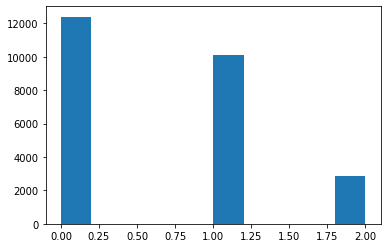

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(np.array(outs==2))

In [ ]:
outs=np.array(outs)
print(outs==2)

[False False False ... False False False]


In [ ]:
gts=np.array(gts)
gts[(outs==2)]

array([0., 0., 0., ..., 0., 1., 1.])

(array([ 907.,    0.,    0.,    0.,    0.,  471.,    0.,    0.,    0.,
        1476.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

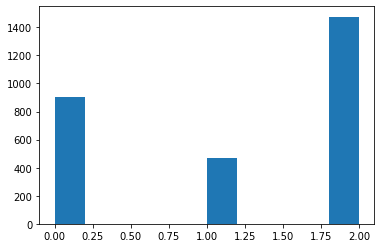

In [ ]:
plt.hist(gts[(outs==2)])

(array([362., 511., 494., 406., 347., 393., 208., 100.,  24.,   9.]),
 array([0.33515814, 0.36523735, 0.39531657, 0.42539578, 0.45547499,
        0.4855542 , 0.51563342, 0.54571263, 0.57579184, 0.60587105,
        0.63595027]),
 <a list of 10 Patch objects>)

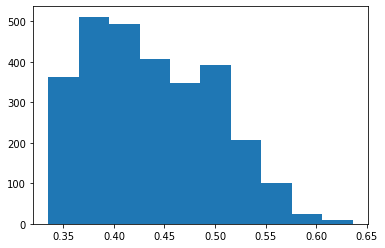

In [ ]:
smdiffs=np.array(smdiffs)
plt.hist(smdiffs[outs==2])

0.5876865671641791


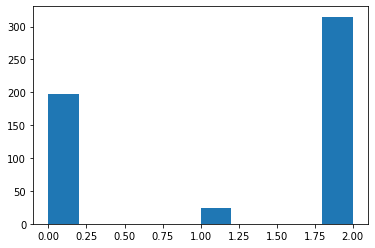

In [ ]:
plt.hist(gts[(smdiffs>=0.5)])
level1 = gts[(smdiffs>=0.5)]
print((level1==2).sum()/((level1==0).sum()+(level1==1).sum()+(level1==2).sum()))

0.6515151515151515


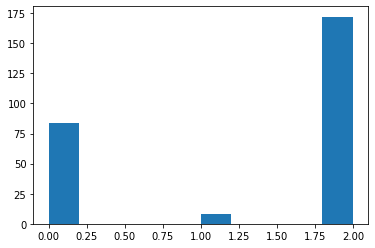

In [ ]:
plt.hist(gts[(smdiffs>=0.525)])
level2 = gts[(smdiffs>=0.525)]
print((level2==2).sum()/((level2==0).sum()+(level2==1).sum()+(level2==2).sum()))

0.6966292134831461


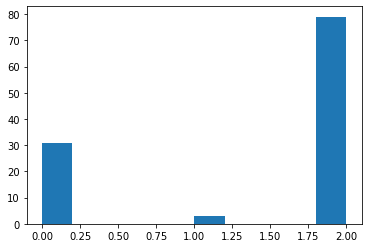

In [ ]:
plt.hist(gts[(smdiffs>=0.55)])
level3 = gts[(smdiffs>=0.555)]
print((level3==2).sum()/((level3==0).sum()+(level3==1).sum()+(level3==2).sum()))

0.8


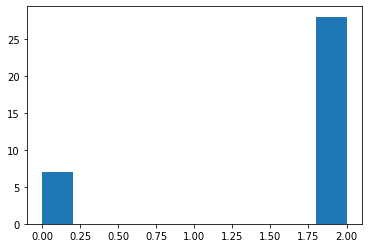

In [ ]:
plt.hist(gts[(smdiffs>=0.575)])
level4 = gts[(smdiffs>=0.575)]
print((level4==2).sum()/((level4==0).sum()+(level4==1).sum()+(level4==2).sum()))